In [1]:
import netCDF4
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from scripts.utils import crop_center_square, transform_color
from datetime import timedelta
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

# Preprocessing for Model Training
This notebook uses TIR data (in netCDF4 format; downloaded from the server), and annotated masks.

Image Preparation Steps:
- center cropping (to an image size of 480x480).
- grayscale conversion (using matplotlib's 'gray' colorscale and then reloading as 1-channel image).

Mask Preparation Steps:
- transform grascale values to 0 : melt pond, 1 : sea ice, 2 : ocean.

Preprocessed images and masks will be stored as numpy arrays in the ```data/``` folder. Those will later be used in the model training function.

In [2]:
# replace with your data paths
flight9_dir = 'E:/polar/code/data/flight9/IRdata_ATWAICE_processed_220718_142920.nc'
flight16_dir = 'E:/polar/code/data/flight16/IRdata_ATWAICE_processed_220730_111439.nc'
annotated_mas_dir = 'E:/polar/code/data/ir/entire/original_size/msks_prep/'

# replace with your desired storage path for preprocessed images
preprocessed_ims_dir = 'E:/polar/code/data/ir/entire/original_size/ims_test03/'

# indeces of preselected training images
idx_9 = [2416, 2380, 2424, 2468, 2476, 2708, 3700, 3884, 4568, 1104]
idx_16 = [100, 200, 256, 64, 260, 552]

### Image Preprocessing Flight 9

In [3]:
ds = netCDF4.Dataset(flight9_dir)
imgs_9 = ds.variables['Ts'][:]

tmp = []

for idx in idx_9:
    im = imgs_9[idx]
    im = crop_center_square(im)
    tmp.append(im)

imgs_train_9 = np.array(tmp)

for idx, img in enumerate(imgs_train_9):
    plt.imsave(os.path.join(preprocessed_ims_dir, '{}.png'.format(idx)), img, cmap='gray')

### Image Preprocessing Flight 16
Due to memory constraints, it might be necessary to restart the kernel and start again without executing the 'Image Preprocessing Flight 9' code chunk.

In [4]:
ds_16 = netCDF4.Dataset(flight16_dir)
imgs_16 = ds_16.variables['Ts'][:]

tmp = []

for idx in idx_16:
    im = imgs_16[idx]
    im = crop_center_square(im)
    tmp.append(im)

imgs_train_16 = np.array(tmp)

for idx, img in enumerate(imgs_train_16):
    # store in the same folder as previous flight, with continuing indeces as names
    plt.imsave(os.path.join(preprocessed_ims_dir, '{}.png'.format(idx + len(idx_9))), img, cmap='gray')

In [10]:
imgs_png = []

for im in os.listdir(preprocessed_ims_dir):
    path = os.path.join(preprocessed_ims_dir, im)
    im = cv2.imread(path, 0)

    imgs_png.append(im)

imgs = np.array(imgs_png)

np.save('./data/training/train_images.npy', imgs)

### Mask Preprocessing

In [7]:
masks_train = []

for f in os.listdir(annotated_mas_dir):
    path = os.path.join(annotated_mas_dir, f)
    mask = cv2.imread(path, 0)
    
    if f == '7.png':
        mask[mask==0] = 0
        mask[mask==76] = 1
        mask[mask==255] = 2
        masks_train.append(mask)

    else:
        mask = transform_color(mask)
        masks_train.append(mask)

masks = np.array(masks_train)
print(np.unique(masks))

np.save('./data/training/train_masks.npy', masks)

[0 1 2]


### Tests
To see if images and masks match: Execute code cell to interactively investigate training images and masks.

(24, 480, 480) (24, 480, 480)


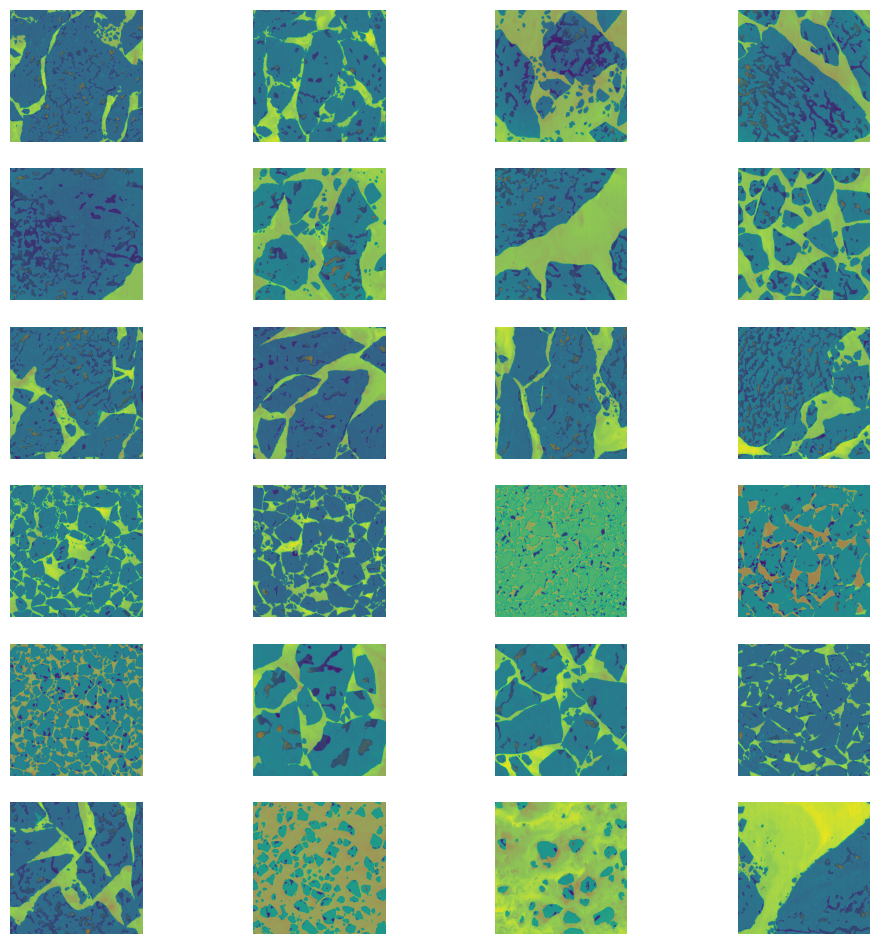

interactive(children=(FloatSlider(value=0.5, description='Alpha Value', max=1.0, step=0.01), Output()), _dom_c…

<function __main__.update_alpha(value)>

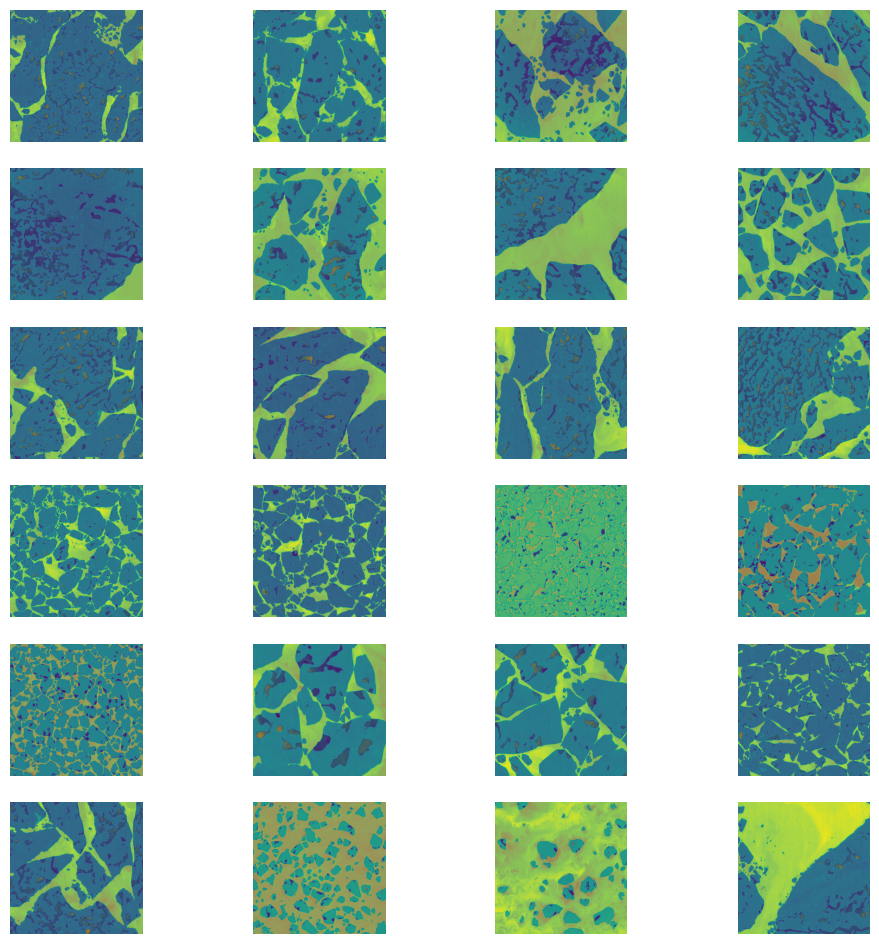

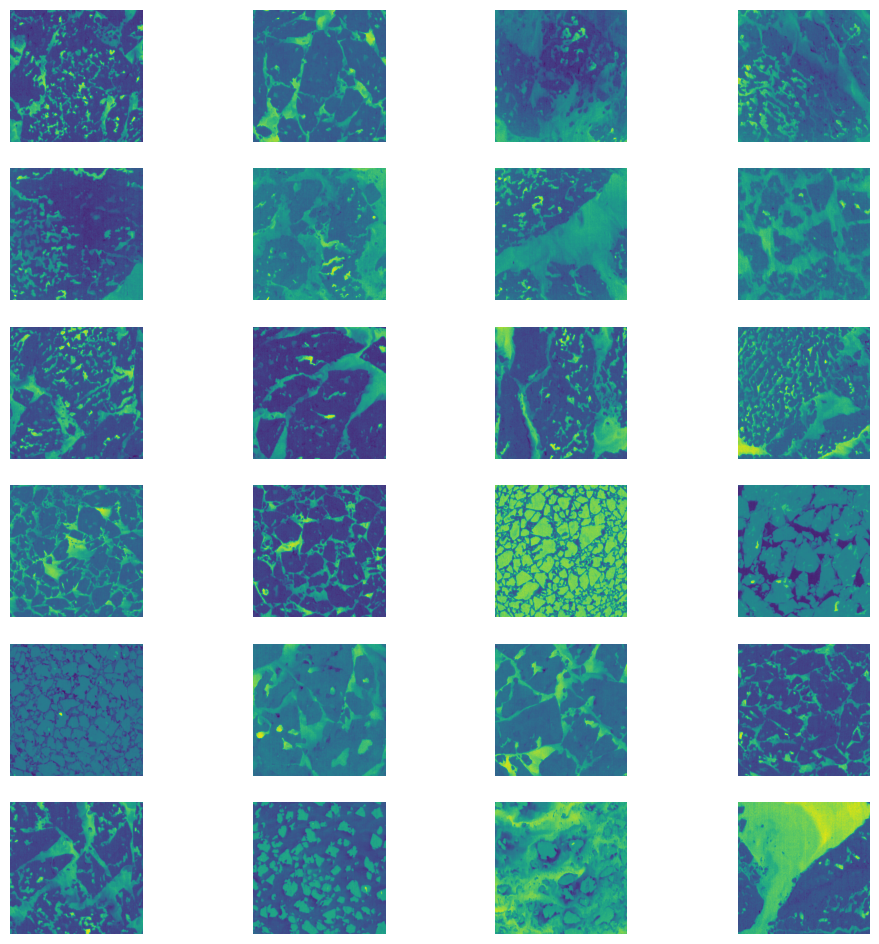

In [10]:
# slider for interaction
slider = FloatSlider(value=0.5, min=0, max=1, step=0.01, description='Alpha Value')

# load data
images = np.load('./data/training/flight9_16_7_11/images_s.npy')
masks = np.load('./data/training/flight9_16_7_11/masks_s.npy')
print(images.shape, masks.shape)

def update_alpha(value):
    """
    Overlay and plot images and masks.

    Parameters:
    -----------
        value : float
            alpha value
    """
    fig, axes = plt.subplots(6, 4, figsize=(12, 12))
    for i in range(25):
        axes[i // 4, i % 4].imshow(images[i])
        axes[i // 4, i % 4].imshow(masks[i], alpha=value)
        axes[i // 4, i % 4].axis('off')

    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, hspace=0.1, wspace=0.1)
    fig.canvas.draw()

# interaction set up
interact(update_alpha, value=slider)